<a href="https://colab.research.google.com/github/imp-etus/Homelessness-Study/blob/main/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The purpose of this notebook is to study HUD data to see whether we can model homelessness based on market factors, and if we can do so in a way that outperforms the HUD report. Additionally, we'll be studying whether district type (rural, urban, suburban) helps predict homelessness rates, and to what degree it does so.

## Import libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

# Import additional libraries

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


from mpl_toolkits.mplot3d import Axes3D

import statsmodels.formula.api as smf
from mpl_toolkits import mplot3d
from matplotlib import cm

from sklearn import linear_model, tree
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
# Model preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm

### tree/xgboost stuff

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

#Train-test splits and cross validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

from scipy.stats import uniform, randint
import xgboost as xgb

# Model metrics and analysis
from sklearn.metrics import  mean_squared_error, mean_absolute_error

# plot tree model
import graphviz

## Load clean data

##### $\rightarrow$ Load the clean data set from Github. 

In [20]:
df = pd.read_csv('https://raw.githubusercontent.com/imp-etus/Homelessness-Study/main/homelessness_data.csv')

##### $\rightarrow$ Review the contents of the data set.

## Analysis

Perform analyses necessary to answer the questions. You will likely start by trying many things, some of which are useful and some of which are not. Don't be afraid to try different analyses at first. You will edit your notebook to a clean version that retains only the essential components at the end of the project.

### Performing basic ridge & lasso analysis taking into account our additional question.

In [ ]:
variable_remove = ["unsheltered_per_10k", "sheltered_per_10k", "year"]
df = df.drop(columns = variable_remove)

x = df[df.columns.difference(['coc_number', 'homeless_per_10k', 'total_population'])]
y = np.log1p(df['homeless_per_10k'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.15, random_state = 786235)

df_train = x_train.join(y_train)
df_test = x_test.join(y_test)

In [22]:
from patsy import dmatrices

### XGBoost predictions

In [56]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True, scoring = 'neg_mean_squared_error')

search.fit(x_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f5be0987640>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f5be07f1510>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f5be07f0bb0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f5be07f0cd0>},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [57]:
search.best_params_

{'colsample_bytree': 0.9574570924902492,
 'gamma': 0.36291974580064823,
 'learning_rate': 0.13058547523888542,
 'max_depth': 5,
 'n_estimators': 111,
 'subsample': 0.6044224454593026}

In [68]:
model_xgb = xgb.XGBRegressor(objective="reg:squarederror", 
                             colsample_bytree=search.best_params_['colsample_bytree'],
                             n_estimators=search.best_params_['n_estimators'],
                             learning_rate=search.best_params_['learning_rate'],
                             max_depth=search.best_params_['max_depth'],
                             subsample=search.best_params_['subsample'],
                             gamma=search.best_params_['gamma'])                            

In [69]:
model_xgb = xgb.XGBRegressor(objective="reg:squarederror")

In [70]:
model_xgb.set_params(**search.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9574570924902492, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.36291974580064823, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.13058547523888542, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=111, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [71]:
model_xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9574570924902492, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.36291974580064823, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.13058547523888542, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=111, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [72]:
y_pred_xgb = model_xgb.predict(x_test)

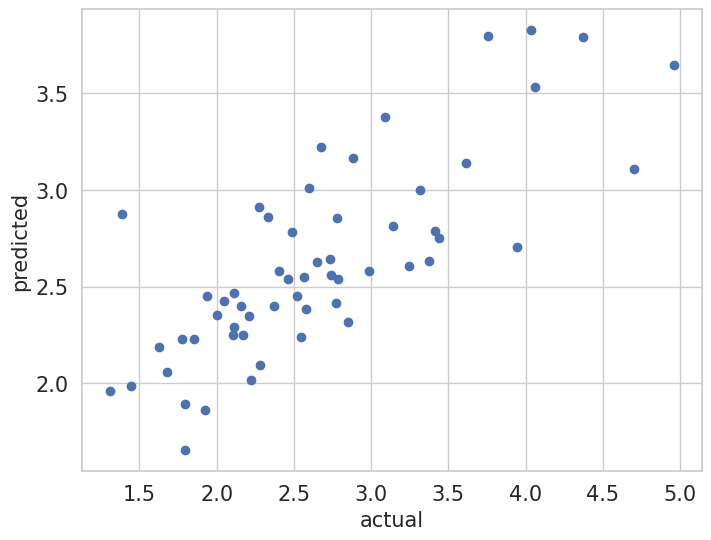

In [73]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_pred_xgb, 'o');

plt.xlabel('actual', fontsize = 15)
plt.ylabel('predicted', fontsize = 15)

plt.tick_params(labelsize = 15)

This seems to generally underpredict the outliers - probably not accounting for certain extreme variables.

In [64]:
mean_squared_error(y_test, y_pred_xgb, squared = False).round(3)

0.524

In [65]:
mean_absolute_error(y_test, y_pred_xgb).round(3)

0.396

This has to use the original dataframes because designmatrixes don't have columns!

We're selecting the most important variables in our design tree.

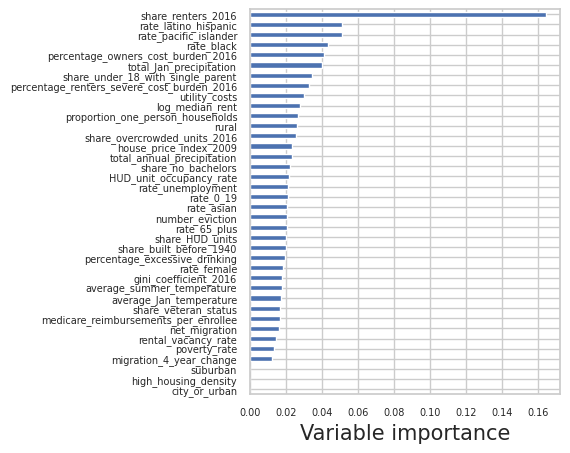

In [75]:
(pd.DataFrame(dict(cols=x_train.columns, imp=model_xgb.feature_importances_)).
 sort_values(by = 'imp').
 plot('cols', 'imp', 'barh', legend = False, figsize = (4,5)))

plt.ylabel('')
plt.xlabel('Variable importance', fontsize = 15)

plt.tick_params(labelsize = 7);

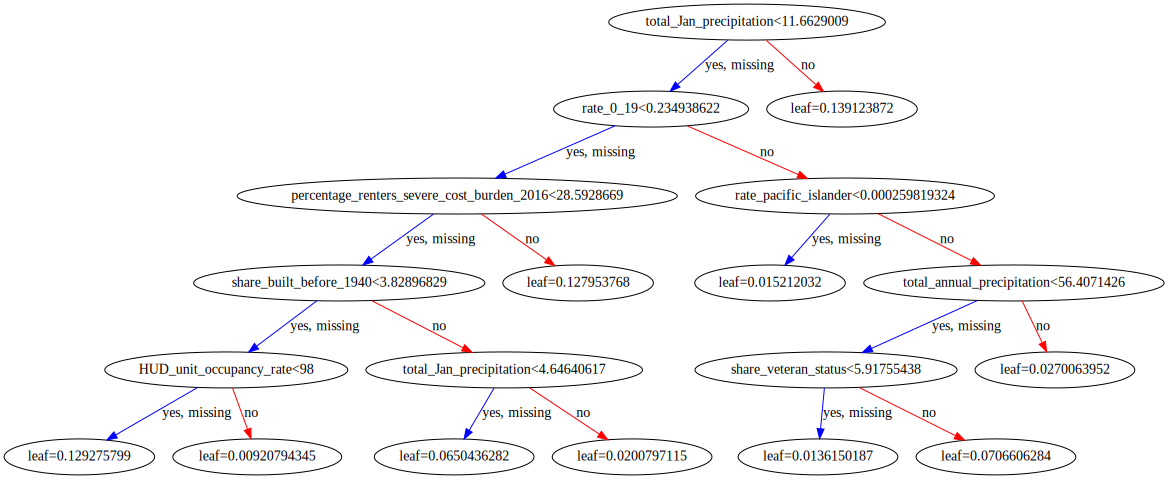

In [76]:
xgb.to_graphviz(model_xgb, num_trees=10) # Try different values of num_trees to plot other trees

### more tree stuff


In [77]:
model = tree.DecisionTreeRegressor()

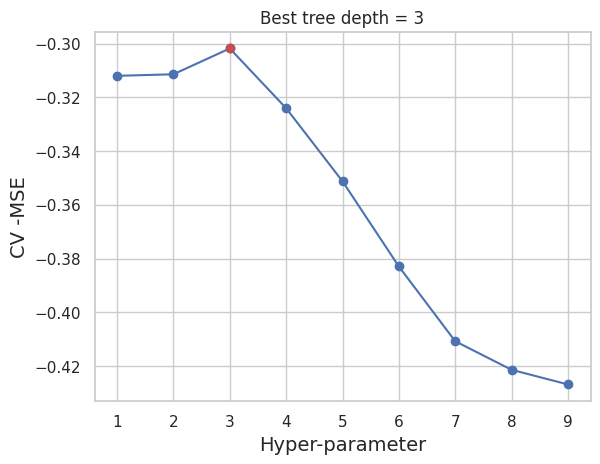

In [78]:
# Values of tree depth to test
parms = np.arange(1,10)
# Define the set of parameters to tune (just tree depth)
tuned_parameters = [{"max_depth": parms}]
# Specify the number of folds
n_folds = 5

# Do the cross validation
modelCV = GridSearchCV(model, tuned_parameters, cv=n_folds, refit=False, scoring = 'neg_mean_squared_error').fit(x2_train, y2_train)

# Get the scores
scores = modelCV.cv_results_["mean_test_score"]

# Get the best value of alpha
best_tree = modelCV.best_params_['max_depth']

# Plot
plt.plot(parms, scores,'o-')
plt.plot(best_tree, scores[parms == best_tree],'ro')

plt.xlabel('Hyper-parameter', fontsize = 14)
plt.ylabel('CV -MSE', fontsize = 14)
plt.title('Best tree depth = ' + str(best_tree));

In [79]:
tree_model2 = tree.DecisionTreeRegressor(max_depth=best_tree)
tree_model2.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [80]:
from sklearn.model_selection import LeaveOneOut

In [81]:
# Values of tree depth to test
parms = np.arange(1,10)
# Define the set of parameters to tune (just tree depth)
tuned_parameters = [{"max_depth": parms}]
# Specify the number of folds
n_folds = 5

In [85]:
# Initialize a list to record the RMSE
tree_rmse = []

# Create the model object
model = tree.DecisionTreeRegressor()

# Create the leave one out object
loo = LeaveOneOut()

# Loop over all splits
for train_index, test_index in loo.split(x):

    x2_train = x.iloc[train_index,:]
    y2_train = y.iloc[train_index]

    x2_test = x.iloc[test_index,:]
    y2_test = y.iloc[test_index]

    # Do the cross validation
    modelCV = GridSearchCV(model, tuned_parameters, cv=n_folds, refit=False, scoring = 'neg_mean_squared_error').fit(x_train, y_train)

    # Get the scores
    scores = modelCV.cv_results_["mean_test_score"]

    # Get the best value of alpha
    best_tree = modelCV.best_params_['max_depth']

    # Fit the model
    tree_model = tree.DecisionTreeRegressor(max_depth=best_tree)

    tree_model.fit(x2_train, y2_train)

    # Predict the left out value
    y_prediction = tree_model.predict(x_test)

    # Record the RMSE
    tree_rmse.append(mean_squared_error(y_test, y_prediction, squared=False))

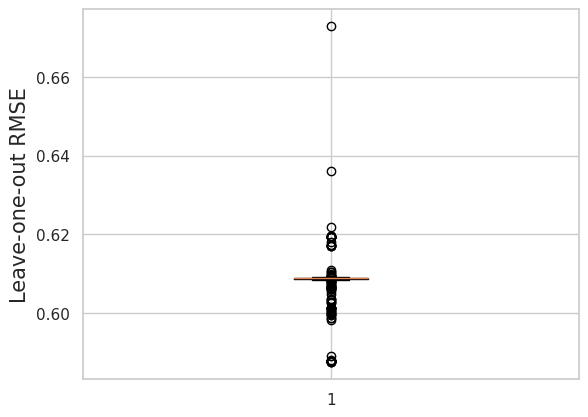

In [86]:
plt.boxplot(tree_rmse);
plt.ylabel('Leave-one-out RMSE', fontsize=15);

In [87]:
pd.DataFrame(tree_rmse).describe()

,0
count,374.000000
mean,0.607954
std,0.006466
min,0.587561
25%,0.608683
50%,0.608797
75%,0.608865
max,0.672933


In [88]:
# Values of tree depth to test
parms = np.arange(1,10)
# Define the set of parameters to tune (just tree depth)
tuned_parameters = [{"max_depth": parms}]
# Specify the number of folds
n_folds = 5

In [89]:
# Initialize a list to record the RMSE
tree_rmse_kfold = []

# Create the model object
model = tree.DecisionTreeRegressor()

# Create the k-folds object with the number of splits
kf = KFold(n_splits=10)

# Loop over all splits
for train_index, test_index in kf.split(x):
    x3_train = x.iloc[train_index,:]
    y3_train = y.iloc[train_index]

    x3_test = x.iloc[test_index,:]
    y3_test = y.iloc[test_index]

    # Do the cross validation
    modelCV = GridSearchCV(model, tuned_parameters, cv=n_folds, refit=False, scoring = 'neg_mean_squared_error').fit(x3_train, y3_train)

    # Get the scores
    scores = modelCV.cv_results_["mean_test_score"]

    # Get the best value of alpha
    best_tree = modelCV.best_params_['max_depth']

    # Fit the best model
    tree_model = tree.DecisionTreeRegressor(max_depth=best_tree)

    tree_model.fit(x3_train, y3_train)

    # Predict
    y3_prediction = tree_model.predict(x3_test)

    tree_rmse_kfold.append(mean_squared_error(y3_test, y3_prediction, squared=False))

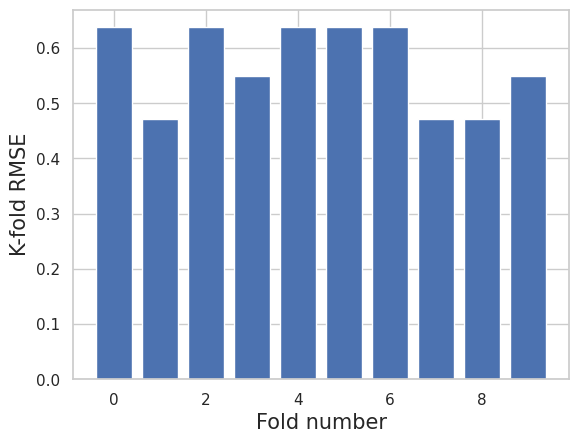

In [90]:
#plt.boxplot(tree_rmse);
plt.bar(np.arange(kf.get_n_splits()), tree_rmse_kfold);
plt.xlabel('Fold number', fontsize=15);
plt.ylabel('K-fold RMSE', fontsize=15);

### Additional step

In [ ]:
predictor_names = df.loc[:, 'house_price_index_2009':'total_annual_precipitation'].columns.values

y2_train, x2_train = dmatrices(f'homeless_per_10k ~ ({" + ".join(predictor_names)}) * (city_or_urban + suburban)', data=df_train)
y2_test, x2_test = dmatrices(f'homeless_per_10k ~ ({" + ".join(predictor_names)}) * (city_or_urban + suburban)', data=df_test)

In [ ]:
y2_city, x2_city = dmatrices(f'homeless_per_10k ~ ({" + ".join(predictor_names)}) * (city_or_urban + suburban)', data=df.loc[df['city_or_urban'] == 1])
y2_suburb, x2_suburb = dmatrices(f'homeless_per_10k ~ ({" + ".join(predictor_names)}) * (city_or_urban + suburban)', data=df.loc[df['suburban'] == 1])
y2_rural, x2_rural = dmatrices(f'homeless_per_10k ~ ({" + ".join(predictor_names)}) * (city_or_urban + suburban)', data=df.loc[df['rural'] == 1])

In [ ]:
alphas = 10**np.linspace(-4,0,10)

In [ ]:
ridge2cv = RidgeCV(alphas = alphas, cv = 6, scoring = 'neg_mean_squared_error')

ridge2cv.fit(x2_train, y2_train);
ridge2cv.alpha_

1.0

In [ ]:
ridge2_reg = Ridge(alpha = ridge2cv.alpha_).fit(x2_train, y2_train)

In [ ]:
MSE_ridge2 = mean_squared_error(y2_test, ridge2_reg.predict(x2_test))
RMSE_ridge2 = np.sqrt(MSE_ridge2)
R_squared_ridge2 = r2_score(y2_test, ridge2_reg.predict(x2_test))

print('MSE =', MSE_ridge2.round(3), ' RMSE =', RMSE_ridge2.round(3), ' R-squared =', R_squared_ridge2.round(3))

MSE = 0.223  RMSE = 0.472  R-squared = 0.659


We're additionally going to use our model on the subsets of our data - city, urban, and rural subsections.

In [ ]:
MSE_ridge2 = mean_squared_error(y2_city, ridge2_reg.predict(x2_city))
RMSE_ridge2 = np.sqrt(MSE_ridge2)
R_squared_ridge2 = r2_score(y2_city, ridge2_reg.predict(x2_city))

print('MSE =', MSE_ridge2.round(3), ' RMSE =', RMSE_ridge2.round(3), ' R-squared =', R_squared_ridge2.round(3))

MSE = 571.502  RMSE = 23.906  R-squared = -1.155


In [ ]:
MSE_ridge2 = mean_squared_error(y2_suburb, ridge2_reg.predict(x2_suburb))
RMSE_ridge2 = np.sqrt(MSE_ridge2)
R_squared_ridge2 = r2_score(y2_suburb, ridge2_reg.predict(x2_suburb))

print('MSE =', MSE_ridge2.round(3), ' RMSE =', RMSE_ridge2.round(3), ' R-squared =', R_squared_ridge2.round(3))

MSE = 257.988  RMSE = 16.062  R-squared = -0.823


In [ ]:
MSE_ridge2 = mean_squared_error(y2_rural, ridge2_reg.predict(x2_rural))
RMSE_ridge2 = np.sqrt(MSE_ridge2)
R_squared_ridge2 = r2_score(y2_rural, ridge2_reg.predict(x2_rural))

print('MSE =', MSE_ridge2.round(3), ' RMSE =', RMSE_ridge2.round(3), ' R-squared =', R_squared_ridge2.round(3))

MSE = 458.575  RMSE = 21.414  R-squared = -0.393


With a RMSE of 16-24, it's not really clear that this was a successful regression model - but it appears our regression model worked well for our base data, where our RMSE is 0.472.

In [ ]:
lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100_000)

In [134]:
lassocv.fit(x2_train, y2_train)
lassocv.alpha_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4053270824159421

In [135]:
lasso_reg = Lasso(alpha = lassocv.alpha_).fit(x2_train, y2_train)

In [136]:
MSE_lasso = mean_squared_error(y2_test, lasso_reg.predict(x2_test))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y2_test, lasso_reg.predict(x2_test))


In [137]:
df_city = ridge2_reg.predict(x2_city)
df_citydesc = pd.DataFrame(df_city)
df_citydesc.describe()

,0
count,104.000000
mean,2.894536
std,0.453907
min,2.077667
25%,2.633883
50%,2.797393
75%,3.105178
max,5.192165


In [138]:
df_suburb = ridge2_reg.predict(x2_suburb)
df_suburbdesc = pd.DataFrame(df_suburb)
df_suburbdesc.describe()

,0
count,160.000000
mean,2.494395
std,0.505647
min,1.424438
25%,2.098703
50%,2.435171
75%,2.715781
max,4.263667


In [139]:
df_rural = ridge2_reg.predict(x2_rural)
df_ruraldesc = pd.DataFrame(df_rural)
df_ruraldesc.describe()

,0
count,110.000000
mean,2.397065
std,0.615957
min,1.643219
25%,1.977682
50%,2.207237
75%,2.650790
max,4.598136


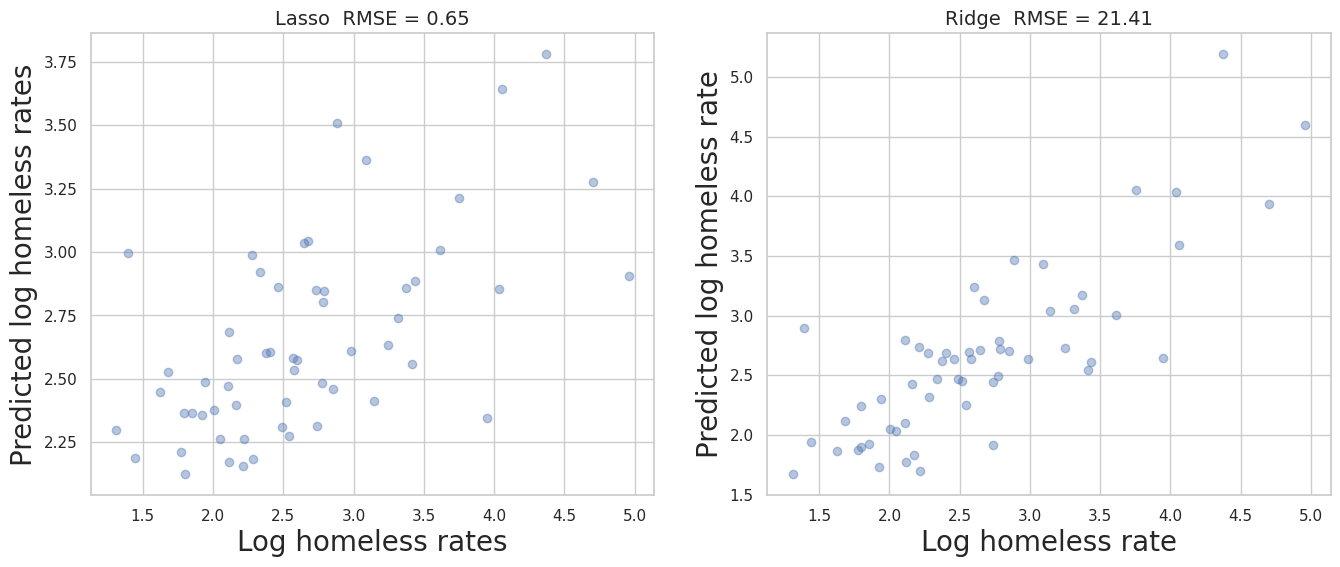

In [140]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(y2_test, lasso_reg.predict(x2_test),'o', alpha = 0.4)
plt.xlabel('Log homeless rates',fontsize = 20)
plt.ylabel('Predicted log homeless rates',fontsize = 20)
plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14)

plt.subplot(1,2,2)
plt.plot(y2_test, ridge2_reg.predict(x2_test),'o', alpha = 0.4)
plt.xlabel('Log homeless rate',fontsize = 20)
plt.ylabel('Predicted log homeless rate',fontsize = 20)
plt.title('Ridge' + ' ' + ' RMSE = ' + str(RMSE_ridge2.round(2)),fontsize = 14);

Text(0.5, 1.0, 'Ridge  RMSE = 21.41')

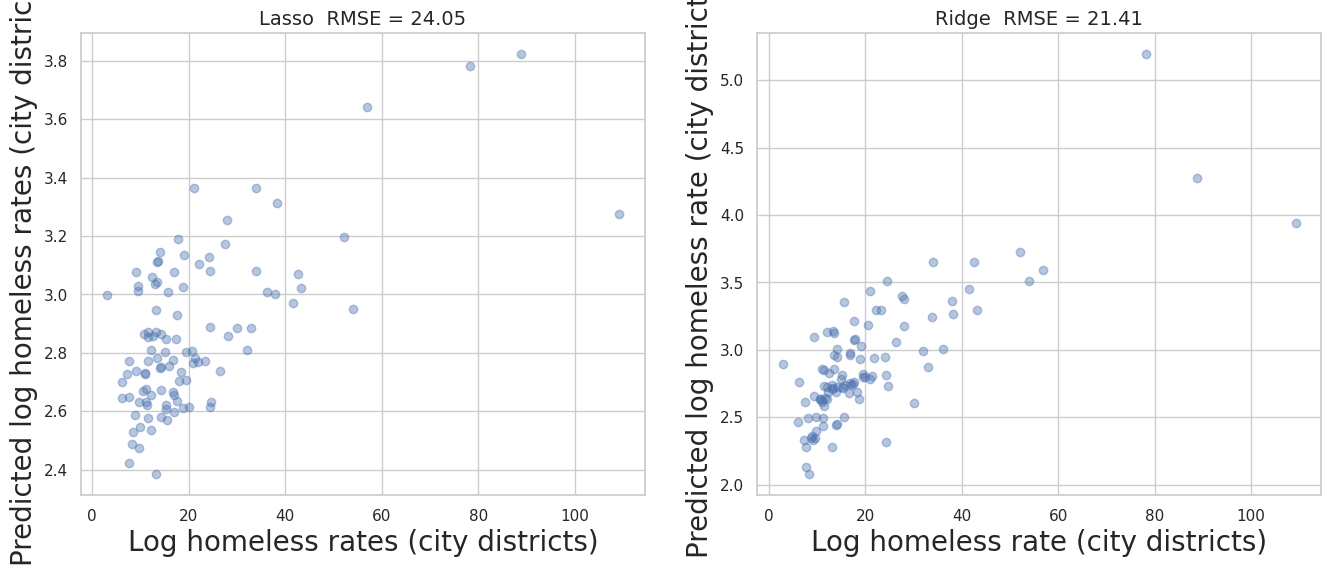

In [141]:
MSE_lasso = mean_squared_error(y2_city, lasso_reg.predict(x2_city))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y2_city, lasso_reg.predict(x2_city))

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(y2_city, lasso_reg.predict(x2_city),'o', alpha = 0.4)
plt.xlabel('Log homeless rates (city districts)',fontsize = 20)
plt.ylabel('Predicted log homeless rates (city districts)',fontsize = 20)
plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14)

plt.subplot(1,2,2)
plt.plot(y2_city, ridge2_reg.predict(x2_city),'o', alpha = 0.4)
plt.xlabel('Log homeless rate (city districts)',fontsize = 20)
plt.ylabel('Predicted log homeless rate (city districts)',fontsize = 20)
plt.title('Ridge' + ' ' + ' RMSE = ' + str(RMSE_ridge2.round(2)),fontsize = 14)

Text(0.5, 1.0, 'Ridge  RMSE = 21.41')

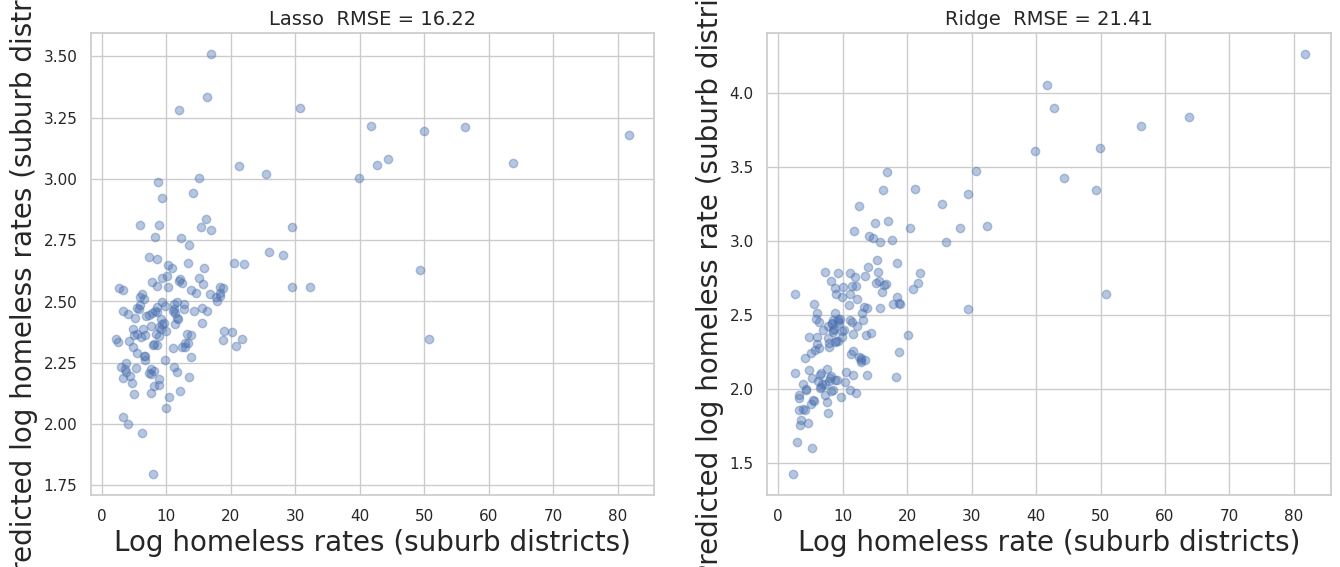

In [142]:
MSE_lasso = mean_squared_error(y2_suburb, lasso_reg.predict(x2_suburb))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y2_suburb, lasso_reg.predict(x2_suburb))

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(y2_suburb, lasso_reg.predict(x2_suburb),'o', alpha = 0.4)
plt.xlabel('Log homeless rates (suburb districts)',fontsize = 20)
plt.ylabel('Predicted log homeless rates (suburb districts)',fontsize = 20)
plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14)

plt.subplot(1,2,2)
plt.plot(y2_suburb, ridge2_reg.predict(x2_suburb),'o', alpha = 0.4)
plt.xlabel('Log homeless rate (suburb districts)',fontsize = 20)
plt.ylabel('Predicted log homeless rate (suburb districts)',fontsize = 20)
plt.title('Ridge' + ' ' + ' RMSE = ' + str(RMSE_ridge2.round(2)),fontsize = 14)

Text(0.5, 1.0, 'Ridge  RMSE = 21.41')

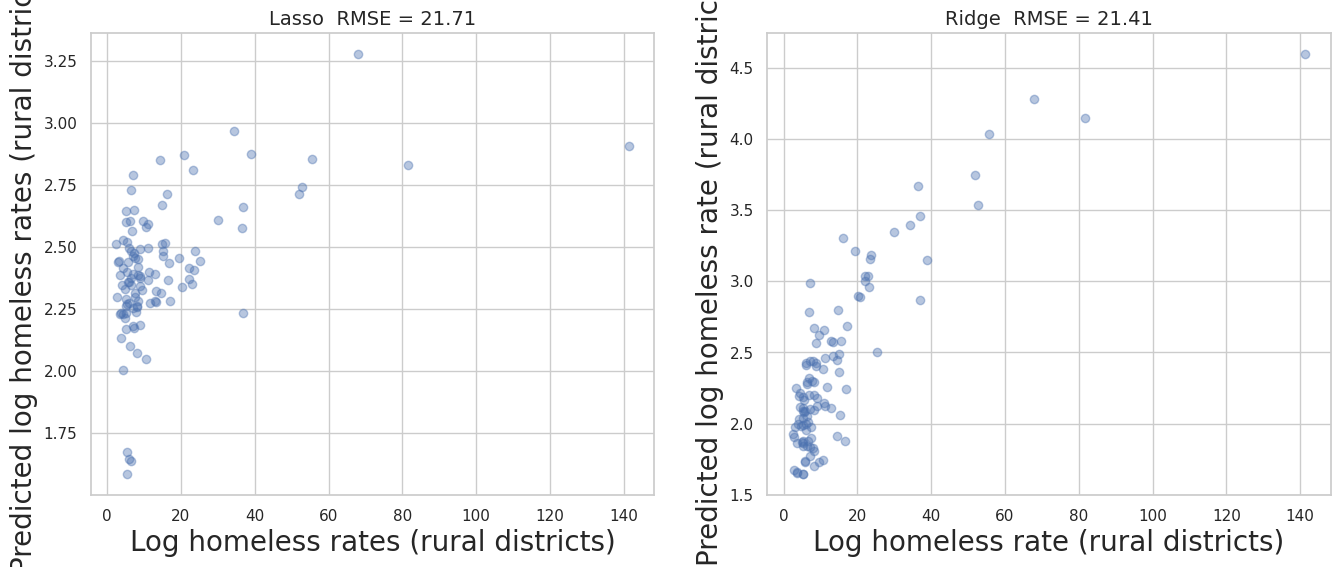

In [144]:
MSE_lasso = mean_squared_error(y2_rural, lasso_reg.predict(x2_rural))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y2_rural, lasso_reg.predict(x2_rural))

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(y2_rural, lasso_reg.predict(x2_rural),'o', alpha = 0.4)
plt.xlabel('Log homeless rates (rural districts)',fontsize = 20)
plt.ylabel('Predicted log homeless rates (rural districts)',fontsize = 20)
plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14)

plt.subplot(1,2,2)
plt.plot(y2_rural, ridge2_reg.predict(x2_rural),'o', alpha = 0.4)
plt.xlabel('Log homeless rate (rural districts)',fontsize = 20)
plt.ylabel('Predicted log homeless rate (rural districts)',fontsize = 20)
plt.title('Ridge' + ' ' + ' RMSE = ' + str(RMSE_ridge2.round(2)),fontsize = 14)

## Conclusion

Provide a brief description of your conclusions.